In [1]:
%run utils.py

In [2]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [3]:
setup_rucio_and_proxy(upload.data[-1])
import rucio.client
import awkward as ak
import fsspec
from coffea.nanoevents.methods import vector
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import dask
from dask import delayed
from dask.distributed import futures_of, wait
import numpy as np
from functools import partial
import time
ak.behavior.update(vector.behavior)

In [4]:
rucio_client = rucio.client.Client()

In [5]:
files = list(rucio_client.list_files("user.nihartma", "user.nihartma.physlite_to_parquet_gcp.data17_13TeV.periodK.grp17_v01_p4309_v3_output.parquet"))

In [7]:
url = get_signed_url(rucio_client, "user.nihartma", files[0]["name"])

In [9]:
def get_m2mu(url, row_groups=None):
    ak.behavior.update(vector.behavior)
    with fsspec.open(url, cache_type="none") as f:
        events = ak.from_parquet(f, lazy=True, row_groups=row_groups)
        p4 = ak.zip({k: events.Muons[k] for k in ["pt", "eta", "phi"]}, with_name="PtEtaPhiMLorentzVector")
        p4["mass"] = 105.6583715
        mu1, mu2 = ak.unzip(ak.combinations(p4, 2))
        return ak.to_numpy(ak.flatten((mu1 + mu2).mass))

In [12]:
get_m2mu(url, 10)

array([18371.81093796, 81543.43982601,  4559.72004804, ...,
       31847.3718676 , 89183.23359825, 89263.42472361])

In [13]:
def get_num_row_groups(url):
    with fsspec.open(url, cache_type="none") as f:
        return pq.ParquetFile(f).num_row_groups

In [14]:
get_num_row_groups(url)

46

In [15]:
from dask_gateway import GatewayCluster, Gateway
cluster = GatewayCluster(
    worker_cores=1,
    worker_memory=3.5,
    image="eu.gcr.io/gke-dev-311213/jupyter-physlite:20210709"
)

In [18]:
cluster

In [17]:
cluster.scale(8)

In [19]:
client = cluster.get_client()

In [21]:
partial_url = partial(get_signed_url_worker, upload.data[-1])

In [35]:
fut_url = client.submit(partial_url, files[0]["scope"], files[0]["name"])

In [37]:
fut_m2mu = client.submit(get_m2mu, fut_url, row_groups=0)

In [38]:
fut_m2mu.result()

array([92185.70863117, 21123.2786062 ,   979.60181011, ...,
       90155.91709156, 88999.88223924,   437.860825  ])

In [31]:
tasks = []
for file in files:
    d_url = delayed(partial_url)(file["scope"], file["name"])
    tasks.append(delayed(get_num_row_groups)(d_url))

In [32]:
num_row_groups_list = dask.compute(*tasks)

In [90]:
def submit():
    futures = []
    for file, num_row_groups in list(zip(files, num_row_groups_list)):
        fut_url = client.submit(partial_url, file["scope"], file["name"])
        sub_tasks = []
        for row_groups in np.array_split(range(num_row_groups), 5):
            if len(row_groups) > 0:
                sub_tasks.append(client.submit(get_m2mu, fut_url, row_groups=list(row_groups)))
        futures.append(client.submit(np.concatenate, sub_tasks))
    return futures

In [91]:
def run(ncores):
    client.restart()
    cluster.scale(ncores)
    current_cores = None
    print("Waiting for cluster to scale")
    start = time.time()
    while current_cores != ncores:
        current_cores = sum(client.ncores().values())
        time.sleep(1)
    print(f"Cluster ready! Took {time.time() - start} s to wait")
    start = time.time()
    futures = submit()
    wait(futures)
    return time.time() - start

In [92]:
#%%time
#run(16)

In [93]:
#client.restart()
#cluster.scale(0)

In [94]:
ncores_list = [64, 128, 256, 384, 512, 768, 1024]
times = []
for ncores in ncores_list:
    print(f"Running for {ncores} cores")
    times.append(run(ncores))
    print(times[-1])
client.restart()
cluster.scale(0)

Running for 64 cores
Waiting for cluster to scale
Cluster ready! Took 121.43381929397583 s to wait
178.7678301334381
Running for 128 cores
Waiting for cluster to scale
Cluster ready! Took 120.92330503463745 s to wait
87.1512861251831
Running for 256 cores
Waiting for cluster to scale
Cluster ready! Took 120.88288187980652 s to wait
53.368602991104126
Running for 384 cores
Waiting for cluster to scale
Cluster ready! Took 131.55643963813782 s to wait
56.732357025146484
Running for 512 cores
Waiting for cluster to scale
Cluster ready! Took 131.43946599960327 s to wait
51.79574680328369
Running for 768 cores
Waiting for cluster to scale
Cluster ready! Took 121.20251441001892 s to wait
61.22903251647949
Running for 1024 cores
Waiting for cluster to scale
Cluster ready! Took 133.9719786643982 s to wait
86.73563718795776


distributed.client - ERROR - Restart timed out after 20.00 seconds


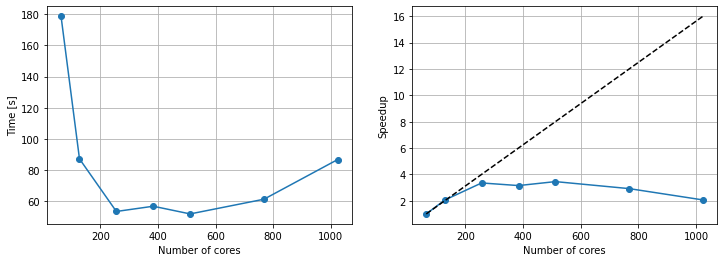

In [96]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(ncores_list, times, "o-")
axs[0].set_xlabel("Number of cores")
axs[0].set_ylabel("Time [s]")
axs[0].grid()
axs[1].plot(ncores_list, times[0] / np.array(times), "o-")
axs[1].plot(ncores_list, np.array(ncores_list) / ncores_list[0], "--", color="black")
axs[1].set_xlabel("Number of cores")
axs[1].set_ylabel("Speedup")
axs[1].grid()
fig.savefig("scaling_test_m2mu_parquet_futures.pdf")

In [97]:
cluster.shutdown()